In [3]:
# imports
import time
import sklearn
import pandas as pd
import numpy
import multiprocess as mp

from PIL import Image, ImageOps, ImageEnhance
from sklearn.metrics import classification_report, accuracy_score
from skimage.feature import hog
from sklearn import svm
from matplotlib import cm


# directorios
train_dir = '../data/processed/train'
test_dir = '../data/processed/test'

train_csv_path = '../data/processed/train_split.txt'
test_csv_path = '../data/processed/test_split.txt'

hogged_imgs_dir = '../data/processed/hogged'

train_fd_csv_path = '../data/processed/train_fd.txt'
test_fd_csv_path = '../data/processed/test_fd.txt'

train_hoged_imgs_csv_path = '../data/processed/train_hogged.txt'
test_hoged_imgs_csv_path = '../data/processed/test_hogged.txt'

In [4]:
train_df = pd.read_csv(train_csv_path, delimiter = ',', header='infer')
test_df = pd.read_csv(test_csv_path, delimiter = ',', header='infer')

In [5]:
train_df.head(10)

,Unnamed: 0,patient_id,image_id,disease,method,ancho,alto
0,0,3,SARS-10.1148rg.242035193-g04mr34g0-Fig8a-day0....,pneumonia,cohen,1692,1474
1,1,3,SARS-10.1148rg.242035193-g04mr34g0-Fig8b-day5....,pneumonia,cohen,1800,1546
2,2,3,SARS-10.1148rg.242035193-g04mr34g0-Fig8c-day10...,pneumonia,cohen,1800,1546
3,3,7,SARS-10.1148rg.242035193-g04mr34g04a-Fig4a-day...,pneumonia,cohen,1772,1800
4,4,7,SARS-10.1148rg.242035193-g04mr34g04b-Fig4b-day...,pneumonia,cohen,1708,1710
5,5,9,SARS-10.1148rg.242035193-g04mr34g07a-Fig7a-day...,pneumonia,cohen,1800,1508
6,6,9,SARS-10.1148rg.242035193-g04mr34g07b-Fig7b-day...,pneumonia,cohen,1800,1522
7,7,10,SARS-10.1148rg.242035193-g04mr34g09a-Fig9a-day...,pneumonia,cohen,1750,1800
8,8,10,SARS-10.1148rg.242035193-g04mr34g09b-Fig9b-day...,pneumonia,cohen,1800,1779
9,9,10,SARS-10.1148rg.242035193-g04mr34g09c-Fig9c-day...,pneumonia,cohen,1787,1800


2.49 segundos


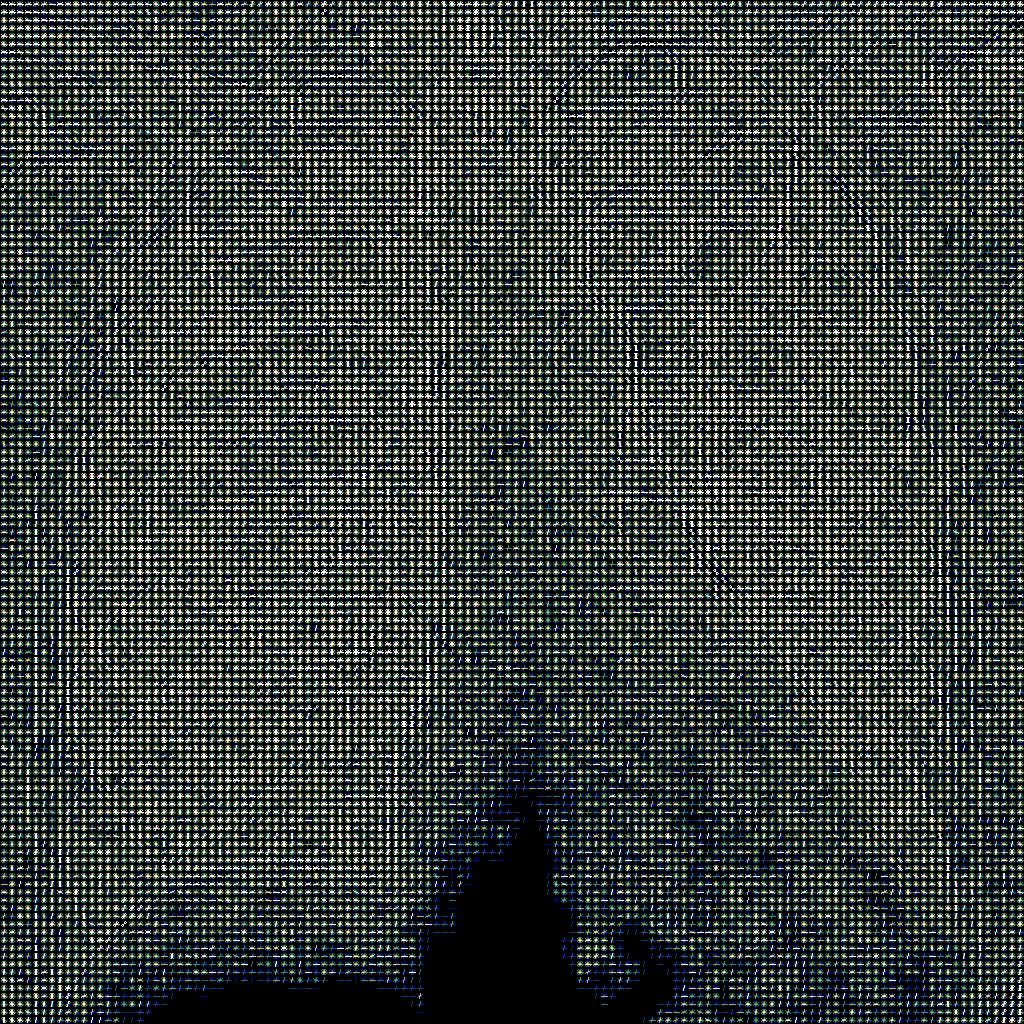

In [6]:
# test una imagen
img1 = test_df['image_id']
start = time.time()
img = Image.open(f'{test_dir}/{img1[0]}')
fd, hoggedImg = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
img.close()
end = time.time()
print(round(end-start, 2), "segundos")
im = Image.fromarray(numpy.uint8(cm.gist_earth(hoggedImg)*255))
im

1 iteración me tarda 2.86 segundos. Teniendo 15.000 imágenes, tendría ~12 horas de procesamiento al hacerlo sincrónicamente.

In [7]:
fd

array([0.00872646, 0.        , 0.        , ..., 0.01187605, 0.03755537,
       0.12993324])

In [8]:
def get_train_hogged_img(id):
    img = Image.open(f'../data/processed/train/{id}')
    fd, hoggedImg = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    img.close()
    return fd, hoggedImg

def get_test_hogged_img(id):
    img = Image.open(f'../data/processed/test/{id}')
    fd, hoggedImg = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    img.close()
    return fd, hoggedImg

In [8]:
start = time.time()
with mp.Pool() as p:
        result_test = p.map(get_test_hogged_img, test_df['image_id'])
end = time.time()

print("conjunto test: ", round(end-start, 2), " segundos")

result_test_df = pd.DataFrame(result_test, columns = ['features', 'hogged_img'])
result_test_df['features'] = result_test_df['features'].apply(lambda x: list(x))
result_test_df.to_csv(test_hoged_imgs_csv_path)
result_test_df.head(10)


conjunto test:  1097.33  segundos


,features,hogged_img
0,"[0.008726461910522227, 0.0, 0.0, 0.07817275923...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,"[0.3270144848975927, 0.0, 0.018498732468792765...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,"[0.2886060421081393, 0.3232476152184495, 0.326...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
5,"[0.014900795920243714, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
6,"[0.3953821145770147, 0.0010726572028767506, 0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
7,"[0.0020656651995510597, 0.0, 0.001460645845265...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
8,"[0.7068614702148582, 0.01351142425733007, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
9,"[0.1303204097606551, 0.004437758813351989, 0.0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [10]:
import swifter


splitted = numpy.array_split(train_df['image_id'], 5)

for fragment in splitted:    
    start = time.time()
    with mp.Pool() as p:
            result_train = p.map(get_train_hogged_img, fragment)
    end = time.time()
    print("conjunto train: ", round(end-start, 2), " segundos")
    result_train_df = pd.DataFrame(result_train, columns = ['features', 'hogged_img'])
    print('cree el df')
    del result_train_df['hogged_img']
    print('borro la columna extra')
    result_train_df['features'] = result_train_df['features'].swifter.apply(lambda x: list(x))
    print('paso arreglo a lista')
    result_train_df.to_csv(train_hoged_imgs_csv_path, mode='a', header=False)
    print('guardo el csv')
    result_train_df.head(10)




conjunto train:  1414.82  segundos
cree el df
borro la columna extra


Pandas Apply:   0%|          | 0/2733 [00:00<?, ?it/s]

paso arreglo a lista
guardo el csv
conjunto train:  1527.61  segundos
cree el df
borro la columna extra


Pandas Apply:   0%|          | 0/2733 [00:00<?, ?it/s]

paso arreglo a lista
guardo el csv
conjunto train:  1723.19  segundos
cree el df
borro la columna extra


Pandas Apply:   0%|          | 0/2733 [00:00<?, ?it/s]

paso arreglo a lista
guardo el csv
conjunto train:  1532.3  segundos
cree el df
borro la columna extra


Pandas Apply:   0%|          | 0/2733 [00:00<?, ?it/s]

paso arreglo a lista
guardo el csv
conjunto train:  1636.96  segundos
cree el df
borro la columna extra


Pandas Apply:   0%|          | 0/2733 [00:00<?, ?it/s]

paso arreglo a lista
guardo el csv
